# Smoking Cessation

Information stored in electronic health records (EHR) can be leveraged to solve numerous healthcare issues and improve the quality and outcomes of the patients served by those systems.  

One fundamental issue when analyzing EHR data is determining what data is stored in discrete data fields as opposed to unstructured data stored in various notes in the health records. During a patient contact data can often times be stored in various notes found in the system. These could be progress notes, procedure notes, consultation notes, discharge notes or others.

Typically, unstructured data found in notes aren't considered useful and discarded, from an analytical perspective, because of the difficulty of gleaning information from the unstructured data. Meaningful use went a long way in ensuring specific data points in an EHR were stored discretely in the system so that they could later be reported on and used to make decisions about the patient or hospital operations. 

However, the gains in natural language processing promises to reevaluate the information tucked away in these unstructured notes in order to identify useful data.

For this project I am looking at using natural language processing techniques to solve the particular patient care issue of smoking cessation. Quiting smoking is beneficial for multiple parts of your body including, lungs, heart, brain, immune system and DNA. A patient can potentially be spared from numerous diseases if they quit smoking.

The data set that I will be using for this project is derived from the [n2c2 NLP Research Data Sets](https://portal.dbmi.hms.harvard.edu/projects/n2c2-nlp/). 

This data set is actually derived from another dataset, the [i2b2 dataset](https://www.i2b2.org) from the Partners Healthcare System in Boston. The data was generated between the years 2004 - 2014 with the expressed purpose of unlocking the hidden potential of unstructured clinical data. The notes have been deidentified and shared publicly for research purposes into natural language processing.

The structure of the n2c2 data sets are as follows:
  * The files are broken up into various different challenges including the following
    * deidentification
    * smoking cessation 
    * obesity
    * medication
    * etc.  
      
  * For our purposes we are using the smoking cessation files which are broken up into a test and train set. Each file consists of an XML file with the discharge summary notes, along with some metadata.
  
  * Lastly, there was a community annotation project that contributed to these files. That project transformed the individual xml files into a json file. An annotation then accompanied each note with various smoking statuses that we can use to train and test our model against.

The training and test original files are stored in the **./data** directory. Here is a screenshot of the original xml file: ![Alt](img/original_file.png "Training Set")

Lastly, the community annotation project is titled [emrQA: A Large Corpus for Question Answering on Electronic Medical Records](https://github.com/panushri25/emrQA)

For our purposes we chose their annotated smoking dataset consisting of 502 patient discharge summary notes. We largley ignored the question and answer pairs along with the associated logic. These were provided along with the dataset but out of scope for the purposes of this project.

Their process for consolidating and annotating their dataset can be found at the link above.

After downloading the **smoking-qa.json** file from the emrQA project I needed to import the data into pandas and  start with some EDA.

## Imports

In [2]:
import json                              #needed to work with the json files from the emrQA project
import pandas as pd  
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#these relate to the models and libraries necessary for name/entity recognition for clinical data
import spacy
import scispacy
import en_core_sci_sm 
import en_ner_bc5cdr_md
from spacy import displacy

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
# various classification models    
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

In [3]:
# general options
plt.style.use('Solarize_Light2')           #solarize because its cool
pd.set_option('max_colwidth', 1000)  
pd.set_option('display.max_rows', 800)

## Reading in Data to Pandas

After reading in the **smoking-qa.json** file the columns only consisted of a row number, a title (in this case smoking for all since I was using the smoking specific file) and most importantly a paragraphs column. That paragraphs columns contained both the note and the question and answer annotations from the emrQA project in a nested JSON format. I needed to convert that JSON into its own dataframe since that would be the data our model would be most concerned with. In doing so I was able to split the question and answer logic from the note text itself.

In [4]:
df = pd.read_json('data/smoking-qa.json')                #read in data from JSON
clin_notes = pd.json_normalize(df['paragraphs'])         #convert JSON data into own dataframe

In [5]:
df.head(1)

,title,paragraphs
0,smoking,"{'note_id': '660', 'qas': [{'question': ['Has the patient quit smoking', 'Has this patient ever tried to quit smoking'], 'id': [[['Has the patient quit smoking', 'Has the patient quit smoking'], ['Has this patient ever tried to quit smoking', 'Has this patient ever tried to quit smoking']], 'SmokingQuitEvent (x)'], 'answers': [{'text': 'PAST SMOKER', 'answer_start': '', 'evidence_start': '', 'evidence': ''}]}, {'question': ['Does the patient have a history of smoking', 'Does this patient have a history of smoking', 'Is there mention of smoking history anywhere in the record', 'smoking habit'], 'id': [[['Does the patient have a history of smoking', 'Does the patient have a history of smoking'], ['Does this patient have a history of smoking', 'Does this patient have a history of smoking'], ['Is there mention of smoking history anywhere in the record', 'Is there mention of smoking history anywhere in the record'], ['smoking habit', 'smoking habit']], 'SmokingUseEvent (x)'], 'answers':..."


## EDA

Once clin_notes was defined as its own dataframe, I could begin my exploratory data analysis. I checked for duplicate note entries with the same note_id and/or note_text (context). This was more problematic in the other emrQA datasets (i.e. obesity and risk).

In [6]:
clin_notes.duplicated(subset ='note_id', keep='first').sum()   #check for duplicate note_ids

0

In addition, I changed the data_type of note_id to an int and set that as the index to the dataset.

In [7]:
clin_notes = clin_notes.astype({'note_id'.strip(): 'int64'})    #changing datatype of index
clin_notes.set_index('note_id'.strip(), inplace=True)           #setting the index to note_id

In [8]:
clin_notes.head(1)

,qas,context
note_id,,
660,"[{'question': ['Has the patient quit smoking', 'Has this patient ever tried to quit smoking'], 'id': [[['Has the patient quit smoking', 'Has the patient quit smoking'], ['Has this patient ever tried to quit smoking', 'Has this patient ever tried to quit smoking']], 'SmokingQuitEvent (x)'], 'answers': [{'text': 'PAST SMOKER', 'answer_start': '', 'evidence_start': '', 'evidence': ''}]}, {'question': ['Does the patient have a history of smoking', 'Does this patient have a history of smoking', 'Is there mention of smoking history anywhere in the record', 'smoking habit'], 'id': [[['Does the patient have a history of smoking', 'Does the patient have a history of smoking'], ['Does this patient have a history of smoking', 'Does this patient have a history of smoking'], ['Is there mention of smoking history anywhere in the record', 'Is there mention of smoking history anywhere in the record'], ['smoking habit', 'smoking habit']], 'SmokingUseEvent (x)'], 'answers': [{'text': 'PAST SMOKER', ...","156406283\nHLGMC\n7213645\n64723/51cy\n5/28/1993 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n5-28-93\nDISCHARGE DATE :\n6-4-93\nHISTORY OF PRESENT ILLNESS :\nThe patient is a 58 year old right hand dominant white male with a long history of hypertension , changed his medications from Aldomet to Clonidine six weeks ago .\nThe patient has a history of adult onset diabetes mellitus , ankylosing spondylitis , status post myocardial infarction in '96 ( ? ) now with acute onset of left face and arm greater than leg hemiplegia and primary hemisensory loss on the left .\nBriefly , he was talking to a friend at 5:30 p.m. the day prior to admission , when he had to grab his locker and sit down .\nHis voice became slurred and he had a mild central dull headache .\nHe was unable to move the left side of his body and felt numb on that side .\nHe was taken to Wayskemedcalltown Talmi and transferred to Heaonboburg Linpack Grant Medical Center with a..."


In [9]:
#data type check
clin_notes.dtypes

qas        object
context    object
dtype: object

I renamed the context column to note_text which is more intuitive for our purposes.

In [10]:
# rename the context column to note_text
clin_notes.rename(columns={'context': 'note_text'}, inplace=True)

Up to this point we have the index in place, a qas column and the note_text itself. The qas column contains the emrQA's project's annotation on whether they believe the discharge note describes a smoker or non smoker. This function and subsequent code pull out this annotation from the JSON format and add it to more discrete columns. These discrete columns can be used to train and test against.

In [11]:
# function to get the smoker classification from a nested list in qas JSON column. One designation per note_id
def get_emrQA_designation(d_frame, note_id):
    ans = [] 
    
    for l in d_frame['qas'][note_id]:
        for k,v in l.items():
            if k == 'answers':
                ans.append(v[0]['text'])
                
    return set(ans).pop()

In [12]:
# add the smoker classification to the dataframe to train and test against
clin_notes['emrQA_class'] = ""

for idx in clin_notes.index:
    clin_notes.loc[idx]['emrQA_class'] = get_emrQA_designation(clin_notes,idx)
    
#adding a smoker non-smoker binary classification to the dataframe to train and test against
clin_notes['emrQA_smoker'] = clin_notes['emrQA_class'].map(defaultdict(lambda: 'UNKNOWN', {'SMOKER': 'SMOKER', 'CURRENT SMOKER': 'SMOKER', 'PAST SMOKER': 'NON-SMOKER', 'NON-SMOKER': 'NON-SMOKER' }))    

#adding a numeric classification of emrQA_class
clin_notes['emrQA_class_num'] = clin_notes['emrQA_class'].map(defaultdict(lambda: None, {'SMOKER': 1, 'CURRENT SMOKER': 1, 'PAST SMOKER': 2, 'NON-SMOKER': 0 }))

#adding a numeric classification of emrQA_smoker
clin_notes['emrQA_smoker_num'] = clin_notes['emrQA_class'].map(defaultdict(lambda: None, {'SMOKER': 1, 'CURRENT SMOKER': 1, 'PAST SMOKER': 0, 'NON-SMOKER': 0 }))

In [13]:
# get distinct values of the emrQA_class from the data
clin_notes.groupby(by='emrQA_class').sum()

,emrQA_class_num,emrQA_smoker_num
emrQA_class,,
CURRENT SMOKER,46.0,46.0
NON-SMOKER,0.0,0.0
PAST SMOKER,94.0,0.0
SMOKER,12.0,12.0
UNKNOWN,0.0,0.0


After the discrete annotations are in as columns I drop the qas column from the dataset.

In [14]:
# drop the qas column no longer needed for our purposes since the emrQA_class is available
clin_notes.drop(['qas'], inplace=True, axis=1)

In [15]:
# function to determine the name of a classification provided by the emrQA team
def is_emrQA_class(d_frame, note_id, class_name):
    if class_name.upper() in {c.upper() for c in set(d_frame['emrQA_class'][note_id])}:
        return True
    else:
        return False

Lastly, there are a number of discharge summary notes that are inconclusive for any smoking status to be determined. These records will be droped from our dataframe. They are represented by the **Unkown** annotation from the emrQA project.

In [16]:
# Removing uknown smoking cessation classifications
unknown_mask = clin_notes['emrQA_class'] != 'UNKNOWN'
clin_notes[unknown_mask].shape

(187, 5)

In [17]:
#double check for null values after removing unknowns
clin_notes[clin_notes[unknown_mask].isna()]

test = clin_notes[unknown_mask]
test.isna().sum()

note_text           0
emrQA_class         0
emrQA_smoker        0
emrQA_class_num     0
emrQA_smoker_num    0
dtype: int64

In [18]:
clin_notes[unknown_mask].groupby(by='emrQA_class').count()['note_text']

emrQA_class
CURRENT SMOKER    46
NON-SMOKER        82
PAST SMOKER       47
SMOKER            12
Name: note_text, dtype: int64

## Further Annotation

At this point in the process, I wasn't completely happy with solely using the annotations from the emrQA project as the truth as for the smoking classifications. I noticed some discrepencies from some preliminary models predictions and the emrQA project. 

Since there are a manageable number of discharge summary notes that were classified as anything other than *unknown*
(187 records), I decided to manually annotate by hand. I read each of the discharge summary notes in order to determine a binary value of smoker or non-smoker. If the dataset was larger I would have enlisted the help of other individuals, preferably clinicians, at this point. The annotation process involved me writing the dataset to a .csv file and manually reading each discharge note. I believe this is appropriate since, though I am not a clinician, I have over 13 years of experience working in healthcare analytics. In addition, understanding a patient's smoking status from the discharge summary note is fairly straight forward.

The one consideration I had during this process is for those patients where current smoking status is ambiguous. For some patients there is smoking information in the note text but it is uncertain if they are a current smoker or if they have smoked in their past. In these cases I erred on the side of annotating them as a smoker. Since this is a program to identify patients for smoking cessation overincluding isn't as much of a problem than missing a patient for potential smoking cessation outreach.

In [19]:
clin_notes[unknown_mask].count()

note_text           187
emrQA_class         187
emrQA_smoker        187
emrQA_class_num     187
emrQA_smoker_num    187
dtype: int64

In [20]:
#write clinical notes to csv file for personal annotation
clin_notes[unknown_mask].to_csv('data/clin_notes_smoke.csv')

In [21]:
#read in annotaded file
cna = pd.read_csv('data/clin_notes_smoke_annotated.csv', index_col='note_id')

#add a numeric column to data set
cna['smoker'] = cna['DM_SMOKER_YN'].map({'Y': 1, 'N': 0})  

A look at the new annotated file after it has been read back into a pandas dataframe.

In [22]:
cna.head(1)

,note_text,emrQA_class,emrQA_smoker,emrQA_class_num,emrQA_smoker_num,DM_SMOKER_YN,DM_SMOKER_CLASS,smoker
note_id,,,,,,,,
660,"156406283\nHLGMC\n7213645\n64723/51cy\n5/28/1993 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n5-28-93\nDISCHARGE DATE :\n6-4-93\nHISTORY OF PRESENT ILLNESS :\nThe patient is a 58 year old right hand dominant white male with a long history of hypertension , changed his medications from Aldomet to Clonidine six weeks ago .\nThe patient has a history of adult onset diabetes mellitus , ankylosing spondylitis , status post myocardial infarction in '96 ( ? ) now with acute onset of left face and arm greater than leg hemiplegia and primary hemisensory loss on the left .\nBriefly , he was talking to a friend at 5:30 p.m. the day prior to admission , when he had to grab his locker and sit down .\nHis voice became slurred and he had a mild central dull headache .\nHe was unable to move the left side of his body and felt numb on that side .\nHe was taken to Wayskemedcalltown Talmi and transferred to Heaonboburg Linpack Grant Medical Center with a...",PAST SMOKER,NON-SMOKER,2.0,0.0,Y,CURRENT,1


In [23]:
#checking values of the newly added binary smoking column.
cna.groupby(by='smoker').count()['note_text']

smoker
0    130
1     57
Name: note_text, dtype: int64

After the annotation process there was indeed one record that I deeemed was mismatched against the emrQA project's classification. Since there are only 187 records that I will be using to develop the model this is fairly significant.

In [24]:
#finding the records that I annotated differently than the emrQA project's annotation
anno_mismatch = (cna['emrQA_smoker_num'] != 1) & (cna['smoker'] == 1)
cna[anno_mismatch]

,note_text,emrQA_class,emrQA_smoker,emrQA_class_num,emrQA_smoker_num,DM_SMOKER_YN,DM_SMOKER_CLASS,smoker
note_id,,,,,,,,
660,"156406283\nHLGMC\n7213645\n64723/51cy\n5/28/1993 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n5-28-93\nDISCHARGE DATE :\n6-4-93\nHISTORY OF PRESENT ILLNESS :\nThe patient is a 58 year old right hand dominant white male with a long history of hypertension , changed his medications from Aldomet to Clonidine six weeks ago .\nThe patient has a history of adult onset diabetes mellitus , ankylosing spondylitis , status post myocardial infarction in '96 ( ? ) now with acute onset of left face and arm greater than leg hemiplegia and primary hemisensory loss on the left .\nBriefly , he was talking to a friend at 5:30 p.m. the day prior to admission , when he had to grab his locker and sit down .\nHis voice became slurred and he had a mild central dull headache .\nHe was unable to move the left side of his body and felt numb on that side .\nHe was taken to Wayskemedcalltown Talmi and transferred to Heaonboburg Linpack Grant Medical Center with a...",PAST SMOKER,NON-SMOKER,2.0,0.0,Y,CURRENT,1


The smoking specific phrase from that mismatch is below. I believe it would be correct to classify this patient as a smoker.

In [47]:
# the actual sentence from the discharge note that was wrongly classified by the emrQA project's classification
# fyi this function is defined later in this notebook
find_smoking_specific_text(cna['note_text'], 660)

['He is a heavy smoker and drinks 2-3 shots per day at times .']

## Model Development

With the dataset in place and annotated, we are going to begin model development. Our model will consist of a simple bag of words approach using the entire discharge summary note text. Below is an example of what a discharge summary note looks like. Subsequent to that I do a train-test split.

In [26]:
# An example of what one of the discharge note texts looks like
print(cna.note_text[109])

782836641 DH
9369592
01111
974771
3/15/2002 12:00:00 AM
OB Discharge Summary
Signed
DIS
Report Status :
Signed OB EMR L and D
DISCHARGE SUMMARY
NAME :
XIEACASS BETHCONRI BALLOON
UNIT NUMBER :
242-36-71
ADMISSION DATE :
20020315
DISCHARGE DATE :
20020318
PRINCIPAL DISCHARGE DIAGNOSIS :
Vaginal Delivery With First Degree Laceration
ASSOCIATED DIAGNOSES :
Advanced Maternal Age ; Depression , history of ; Hepatitis C Antibody Positive ; Polyneuropathy , history of ; Problems With Abuse , history of ; Rh Nonsensitization ; Stopped Smoking This Pregnancy , history of
PRINCIPAL PROCEDURE OR OPERATION :
Spontaneous Vertex Vaginal Delivery
ASSOCIATED PROCEDURES OR OPERATIONS :
POSTPARTUM DIAGNOSTIC PROCEDURES :
None
POSTPARTUM THERAPEUTIC PROCEDURES :
None
HISTORY AND REASON FOR HOSPITALIZATION :
Active Labor
PHYSICAL EXAMINATION :
HEIGHT NORMAL 66 HEENT NORMAL MOUTH NORMAL NECK NORMAL BREASTS NORMAL NIPPLES NORMAL CHEST NORMAL COR NORMAL ABDOMEN NORMAL EXTREM NORMAL SKIN mottled on both lower 

In [27]:
# Define X and y matrices
X = cna.note_text
y = cna.smoker

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

I setup a CountVectorizer which will create a sparse matrix for my bag of words model. I show later on how I got to a ngram range of 3 to 6 but adding it in here to help with showing the vocabulary for the chosen model.

In [28]:
#Count Vectorizer
#I decided
vect = CountVectorizer(ngram_range=(3,6), stop_words='english')
X_train_dtm = vect.fit_transform(X_train)    #creating training document term matrix
X_test_dtm = vect.transform(X_test)          #creating test document term matrix

X_train_dtm.shape

(140, 290696)

In [29]:
# Last 50 features
print((vect.get_feature_names()[-50:]))

['zoster status post ovarian cyst', 'zoster status post ovarian cyst resection', 'zp2 sf477 5317', 'zp2 sf477 5317 batch', 'zp2 sf477 5317 batch 31967', 'zp2 sf477 5317 batch 31967 index', 'zro dd 06', 'zro dd 06 15', 'zro dd 06 15 2005', 'zro dd 06 15 2005 td', 'zs dd 03', 'zs dd 03 06', 'zs dd 03 06 97', 'zs dd 03 06 97 td', 'zustbelbkurk ageoff at93', 'zustbelbkurk ageoff at93 02', 'zustbelbkurk ageoff at93 02 22', 'zustbelbkurk ageoff at93 02 22 06', 'zustbelbkurk ageoff potentially', 'zustbelbkurk ageoff potentially interaction', 'zustbelbkurk ageoff potentially interaction potassium', 'zustbelbkurk ageoff potentially interaction potassium chloride', 'zx 681 0201', 'zx 681 0201 rishan', 'zx 681 0201 rishan mishon', 'zx 681 0201 rishan mishon room', 'zyprexa cardiovascular patient', 'zyprexa cardiovascular patient echocardiogram', 'zyprexa cardiovascular patient echocardiogram revealed', 'zyprexa cardiovascular patient echocardiogram revealed normal', 'zyprexa mg 14', 'zyprexa mg 1

In [30]:
#3-6 ngram vocabulary
vect.vocabulary_

{'407060601 fih 9835577': 22604,
 'fih 9835577 74261': 119419,
 '9835577 74261 1069': 30831,
 '74261 1069 663014': 26670,
 '1069 663014 01': 7453,
 '663014 01 12': 25779,
 '01 12 1992': 1110,
 '12 1992 12': 8854,
 '1992 12 00': 13699,
 '12 00 00': 8400,
 '00 00 discharge': 96,
 '00 discharge summary': 436,
 'discharge summary unsigned': 97295,
 'summary unsigned dis': 261116,
 'unsigned dis report': 279127,
 'dis report status': 95195,
 'report status unsigned': 233472,
 'status unsigned admission': 257278,
 'unsigned admission date': 279052,
 'admission date 01': 34793,
 'date 01 12': 83137,
 '01 12 92': 1114,
 '12 92 discharge': 9115,
 '92 discharge date': 28886,
 'discharge date 02': 95484,
 'date 02 01': 83230,
 '02 01 92': 1601,
 '01 92 patient': 1427,
 '92 patient 80': 28988,
 'patient 80 year': 198458,
 '80 year old': 27466,
 'year old right': 289663,
 'old right handed': 191071,
 'right handed female': 238316,
 'handed female nun': 129777,
 'female nun admission': 118176,
 'nun

In [31]:
#the sparse array
X_train_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
#Term Frequency
tf = pd.DataFrame(vect.fit_transform(X).toarray(), columns=vect.get_feature_names())
tf.T

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
00 00 00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00 00 00 barium,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00 00 00 barium swallow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00 00 00 barium swallow impression,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00 00 abdominal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyprexa physical examination general chronically ill,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zyrtec prozac trazodone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
zyrtec prozac trazodone humulin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
zyrtec prozac trazodone humulin 70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


I want to compare my models accuracy to the null accuracy. I calculate that null accuracy below. Non-smoker is the most frequent classification so if we happened to choose all cases in the test set as non-smokers we would be correct 70% of the time. If our model does better than that then we are doing well.

In [33]:
# Calculate null accuracy.
print('Percent Current Smoker:', y_test.mean())
print('Percent Not Current Smoker:', 1 - y_test.mean())

Percent Current Smoker: 0.2978723404255319
Percent Not Current Smoker: 0.7021276595744681


This function is set up to compare the various model feature counts and accuracy of each model given the count vector, and the train test split matrices/vectors.

I use this function in the next cell to find the best ngram start assuming that 10 would be the highest ngram end I would like. I did some analysis with higher ngram upper bounds and noticed the accuracy coming down for a simple Naive Bayes model. 

This function compares the accuracy of the Naive Bayes, Logistic Regression and KN Nearest Neighbors to determine the best model and ngram lower bound.

Naive Bayes won in the end but I think I could perhaps tune the Logistic Regression to get pretty close. Most importantly is that both beat the null accuracy score.

Also, an ngram lower bound of 3 was determined to be optimal for the Naive Bayes models and a lower bound of 1 was better for the Logistric Regression model.

In [34]:
#function to test accuracy
def model_accuracy_test(vect, pX_train, pX_test, py_train, py_test):
    ret_dict = {}
    
    X_train_dtm = vect.fit_transform(pX_train)
    print(('Features: ', X_train_dtm.shape[1]))
    
    X_test_dtm = vect.transform(pX_test)
    
    nb = MultinomialNB()
    nb.fit(X_train_dtm, py_train)
    y_pred_class = nb.predict(X_test_dtm)
    ret_dict['Naive Bayes'] = metrics.accuracy_score(py_test, y_pred_class)
    
    logr = LogisticRegression()
    logr.fit(X_train_dtm, py_train)
    y_pred_class = logr.predict(X_test_dtm)
    ret_dict['Logistic Regression'] = metrics.accuracy_score(py_test, y_pred_class)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_dtm, py_train)
    y_pred_pos = knn.predict(X_test_dtm)
    ret_dict['KNN'] = metrics.accuracy_score(py_test, y_pred_class)
    
    return ret_dict

In [35]:
#choosing the best model and best ngram parameter
for x in range(1,11):
    v = CountVectorizer(ngram_range=(x,10), stop_words='english')
    print(f'ngram {x} - 10')
    print(model_accuracy_test(v, X_train, X_test, y_train, y_test))
    print('')


ngram 1 - 10
('Features: ', 657879)
{'Naive Bayes': 0.7446808510638298, 'Logistic Regression': 0.7446808510638298, 'KNN': 0.7446808510638298}

ngram 2 - 10
('Features: ', 648157)
{'Naive Bayes': 0.7446808510638298, 'Logistic Regression': 0.723404255319149, 'KNN': 0.723404255319149}

ngram 3 - 10
('Features: ', 598657)
{'Naive Bayes': 0.7659574468085106, 'Logistic Regression': 0.723404255319149, 'KNN': 0.723404255319149}

ngram 4 - 10
('Features: ', 532374)
{'Naive Bayes': 0.7021276595744681, 'Logistic Regression': 0.723404255319149, 'KNN': 0.723404255319149}

ngram 5 - 10
('Features: ', 459569)
{'Naive Bayes': 0.574468085106383, 'Logistic Regression': 0.7021276595744681, 'KNN': 0.7021276595744681}

ngram 6 - 10
('Features: ', 384261)
{'Naive Bayes': 0.5957446808510638, 'Logistic Regression': 0.7021276595744681, 'KNN': 0.7021276595744681}

ngram 7 - 10
('Features: ', 307961)
{'Naive Bayes': 0.7021276595744681, 'Logistic Regression': 0.7021276595744681, 'KNN': 0.7021276595744681}

ngram 

## Stemming and Lemming

Since I am looking at the entire discharge summary note text to use in the model I thought perhaps some lemming and/or stemming could positively affect the model. Especially in terms of identifying the permutations of smoke, smoking, smoker etc. 

However, I found that adding either lemming or stemming to the note_text had a detrimental affect on the model.

In [36]:
# Define a function that accepts text and returns a list of lemmas.
def note_stemmarize(text):
    stemmer = SnowballStemmer('english')
    
    text = str(text).lower()
    words = TextBlob(text).words
    return [stemmer.stem(word) for word in words]

In [37]:
# Define a function that accepts text and returns a list of lemmas.
def note_lemmatize(text):
    text = str(text).lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [38]:
#Setup the CountVector while lemmatizing the input
vect_lemm = CountVectorizer(ngram_range=(3,10), 
                       stop_words='english', 
                       analyzer=note_lemmatize, 
                       decode_error='replace')

X_train_dtm = vect_lemm.fit_transform(X_train)    #creating training document term matrix
X_test_dtm = vect_lemm.transform(X_test)          #creating test document term matrix

X_train_dtm.shape

(140, 11266)

In [39]:
# Use Naive Bayes to predict smoking status
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.7446808510638298


In [40]:
#Setup the CountVector while getting the stem of the input
vect_stem = CountVectorizer(ngram_range=(3,10), 
                       stop_words='english', 
                       analyzer=note_stemmarize, 
                       decode_error='replace')

X_train_dtm = vect_stem.fit_transform(X_train)    #creating training document term matrix
X_test_dtm = vect_stem.transform(X_test)          #creating test document term matrix

X_train_dtm.shape

(140, 10187)

In [41]:
# Use Naive Bayes to predict smoking status
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.7446808510638298


## Name Entity Recognition

I was actually quite pleased with an over 76% accuracy rate to determine the smoking status of a patient from the full text of the discharge summary note. That is a six percent increase over the null accuracy score without doing much more than reading in the note text and running the model. However, there is a lot of noise in the note text itself and I wanted a way to gather more specific or discrete information from the note text and potentially use that information in the model.

Creating a model that would identify entities within the note text is beyond the scope of what could be done in this project. Fortunately, however there are a couple of open source libraries that can be used for just this purpose. 

For named-entity recogniztion I used the [spaCy](https://spacy.io) library. This is really a the main library that will split certain text chunks into specific entities. The following libraries build on this library to recognize biomedical information and medication information specifically.

To identify the specific diseases or conditions in the note text I used [scispaCy](https://allenai.github.io/scispacy/). This is a library and associated models to identify biomedical entities within the note text. This was used to generate a problem list for each patient derived from the note_text.

And finally to identify medications that a patient was using I choose the [med7](https://github.com/kormilitzin/med7) library and model. With this I was able to identify medications from the discharge note and create a medication list for each patient discharge.

An example using the third record in our dataset for the named entity recognition

In [42]:
#loading NER models
sci_nlp   = spacy.load('en_core_sci_sm')   #scispaCy model
nlp_bc    = en_ner_bc5cdr_md.load()        #scispaCy biomedical entity model
med_nlp   = spacy.load('en_core_med7_lg')  # med7 model

In [43]:
#parsing the note_text for NER
prob_doc   = nlp_bc(X.iloc[3])
med_doc   = med_nlp(X.iloc[3])

The library was able to identify specific diseases and chemicals from the note text, those entities and labels are highlighted below.

In [44]:
spacy.displacy.render(prob_doc, style='ent', jupyter=True)

Similarly, medications and information from the sig was able to be identified from the note text.

In [45]:
spacy.displacy.render(med_doc, style='ent', jupyter=True)

## Feature Engineering

The goal now is to improve my model by updating and adding features to the model. Since I am able to use named entity recognition (NER) to generate a problem list as well as a medication list from the labeled entities in the note text, I would like to add those lists as features to the model.

First, however, I would like to lower the amount of text that is being fed into the CountVectorizer. I would like to identify the sentences or phrases that contain only the information relevant to smoking if it exists in the note text. The below function solves this problem by using [TextBlob](https://textblob.readthedocs.io/en/dev/) to parse the entire note text. The function then reads each sentence in the note text to determine if it contains one of the following strings fragments.
* SMOK
* TOBACCO
* CIG

An array of all matching sentences is related to smoking is then returned and that subset of the note text will be fed into the CountVectorizer for our bag of words analysis.

As an aside, I did do some analysis on what string or fragments are typically found in order to identify a smoking related phrase and these are the three I came up with.

In [46]:
def find_smoking_specific_text(d_frame, note_id):
    smoke_list = ['SMOK','TOBACCO','CIG']
    smoke_sents = []

    for s in TextBlob(d_frame.loc[note_id]).sentences:
        for t in smoke_list:
            if t in str(s).upper():
                smoke_sents.append(str(s))

    return list(set(smoke_sents))

In [48]:
#An example smoking related phrase
find_smoking_specific_text(X,515)

['She cut down dramatically on smoking two years ago , but has continued to smoke , although , very recently , she admits to only " two puffs " per day .']

Now that the smoking phrase is able to derived, our note text is a bit more focused for smoking cessation than the entire discharge note itself, I would like to see a frequency table of the features derived from the CountVectorizer.

In [49]:
df_cna = cna
smoking_text = []

for idx in df_cna.index:
    smoking_text.append(".".join(find_smoking_specific_text(df_cna['note_text'],idx)))

df_cna['smoking_text'] = smoking_text

In [50]:
# Document frequency
Xfreq = df_cna.smoking_text

vfreq = CountVectorizer(ngram_range=(3,6), binary=True, stop_words='english')
d = vfreq.fit_transform(Xfreq).toarray().sum(axis=0)
df_doc = pd.DataFrame(d.reshape(1, len(d)), columns=vfreq.get_feature_names())

#list of smoking related phrases as features
vfreq.get_feature_names()

['00 00 discharge',
 '00 00 discharge summary',
 '00 00 discharge summary signed',
 '00 00 discharge summary signed dis',
 '00 00 ob',
 '00 00 ob discharge',
 '00 00 ob discharge summary',
 '00 00 ob discharge summary signed',
 '00 discharge summary',
 '00 discharge summary signed',
 '00 discharge summary signed dis',
 '00 discharge summary signed dis admission',
 '00 ob discharge',
 '00 ob discharge summary',
 '00 ob discharge summary signed',
 '00 ob discharge summary signed dis',
 '0010 admitted life',
 '0010 admitted life valley',
 '0010 admitted life valley medical',
 '0010 admitted life valley medical center',
 '01 50pm scheduled',
 '01 50pm scheduled known',
 '01 50pm scheduled known allergies',
 '01 50pm scheduled known allergies admit',
 '01111 974771 15',
 '01111 974771 15 2002',
 '01111 974771 15 2002 12',
 '01111 974771 15 2002 12 00',
 '02 2003 report',
 '02 2003 report status',
 '02 2003 report status signed',
 '02 2003 report status signed discharge',
 '02 admission date

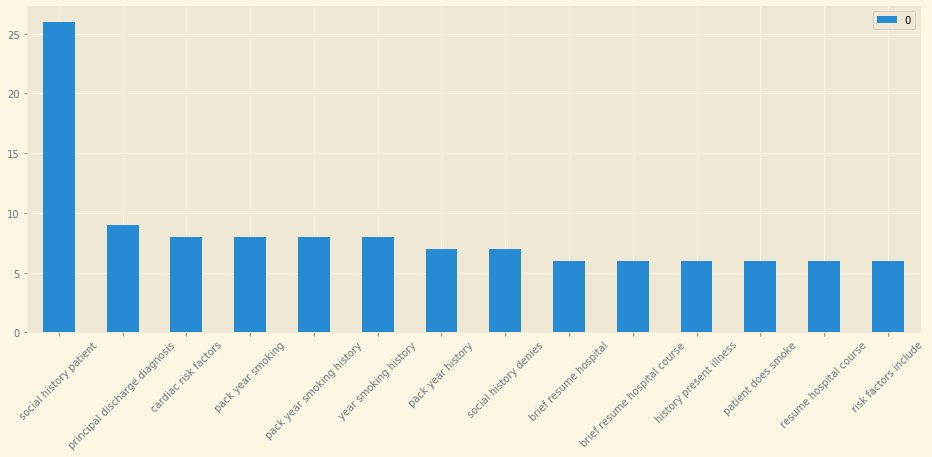

In [51]:
#chart of a sample of high document count features
df_doc.T[df_doc.T[0] >= 6].sort_values(by=0, ascending=False).plot(kind='bar', figsize=(16,6), rot=45);

When exploring the data I got a hunch that whether or not a person drank alcohol seemed to correlate with their smoking status. More specifically, if a person didn't drink it seemed to follow that they often didn't smoke as well. This is completely anecdotal but I would like to dig into this a bit more. I wanted to find a way to identify the phrases or sentences in the note text that had to deal with alchohol consumption. Then I attempted to generate a positive or negative number by applying TextBlob's sentiment method to the phrase. No drinking seemed to return positive values while heavy drinker seemed to negative positive values. However I don't think I could isolate just the part of the sentence that dealt with alchohol in particular. This needs more work.

As an aside, I didn't know how to check correlations with features that were part of an NLP analysis. These features were really word(s) in a sparse matrix so a heatmap didn't seem appropriate. Definitely an area I would like to explore in the future.

In [52]:
def find_alcohol_sentiment(d_frame, note_id):
    alcohol_list = ['ALCOHOL','DRINK','ETHANOL','BEER','LIQUOR']
    alcohol_sents = []
    alcohol_sents_sentiment = []

    for s in TextBlob(d_frame.loc[note_id]).sentences:
        for t in alcohol_list:
            if t in str(s).upper():
                alcohol_sents.append(str(s))

    for s in list(set(alcohol_sents)):
        alcohol_sents_sentiment.append(TextBlob(s).sentiment.polarity)

    return np.mean(alcohol_sents_sentiment)

In [53]:
"nSOCIAL HISTORY :\nShe does not drink "

'nSOCIAL HISTORY :\nShe does not drink '

In [54]:
#an example of alchohol sentiment
find_alcohol_sentiment(X,515)

0.03333333333333333

Using my newfound NER powers I wanted to generate a medication list from the given note text. This is the function that does that. In addition, I added a function that looks through the medical specific entities for the word **puff**. In this way I could identify patients that have a medication that is inhaled and this medication route could prove to be a useful feature in my model.

In [55]:
#loading model for MED7 nlp
med_nlp = spacy.load('en_core_med7_lg')

#function definition
def get_drugs(d_frame, note_id):
    medication = []
    med_doc = med_nlp(d_frame.loc[note_id]) 
    
    for e in med_doc.ents:
        if e.label_ == 'DRUG':
            medication.append(str(e).title())

    return list(set(medication))

def get_inhaler(d_frame, note_id):
    fnd = 0
    med_doc = med_nlp(d_frame.loc[note_id]) 
    for e in med_doc.ents:
        if 'PUFF' in str(e).upper():
            fnd = 1
    return fnd

In [56]:
#Medication List example
(get_drugs(X, 265))

['Percocet', 'Folate', 'Multivitamins']

In [57]:
#Inhaler example
get_inhaler(cna['note_text'],515)

1

This is the function to determine the patients problem list from the note text.

In [58]:
#Load model for scispaCy NEW
sci_nlp = spacy.load('en_core_sci_sm')

#Load Biomedical NER from scispacy
nlp_bc = en_ner_bc5cdr_md.load()

def get_problem_list(d_frame, note_id):
    prob_doc = nlp_bc(d_frame.loc[note_id])
    disease = []

    for e in prob_doc.ents:
        if e.label_ == 'DISEASE':
            disease.append(str(e).title())

    return list(set(disease))

In [59]:
get_problem_list(X,265)

['Anemia', 'Arrhythmia', 'Urinary Tract Infection', 'Herpes Simplex']

Given the above functions I now want to add new columns for problem list, medication list, inhaler. Unfortunately, I noticed that the bag of words approach to problem list and medication list didn't really move the needle on the accuracy of my models much. In fact, the model accuracy was dropped when I added the bag of words approach for the medication list alone. My assumption was that certain medications would pertain to smokers vs non-smokers. The count of those medications in smokers vs non-smokers should help the model predict. But, the opposite happened.

So I decided to be a bit more targeted. I parsed the problem list and medication list to find diseases (i.e. lung disease, cancer, asthma and COPD) or medications (i.e. vanceril) that may correlate to a person that is currently a smoker. 

The code below adds these features to the dataframe. Then I instantiate the CountVectorizer with the parameters that we've been using throughout. Lastly I define the sparse matrices comprising the various different features and combine the ones that I think would provide the biggest bump in accuracy.

In [60]:
#columns before the additions
cna.columns

Index(['note_text', 'emrQA_class', 'emrQA_smoker', 'emrQA_class_num',
       'emrQA_smoker_num', 'DM_SMOKER_YN', 'DM_SMOKER_CLASS', 'smoker',
       'smoking_text'],
      dtype='object')

In [64]:
# creating arrays of the newly defined features using the functions defined above
# this step takes some time
med_list = []
prob_list = []
smoking_sents = []
alcohol_sentiment = []

for idx in cna.index:
    med_list.append(";".join(get_drugs(cna['note_text'],idx)))
    prob_list.append(";".join(get_problem_list(cna['note_text'],idx)))
    smoking_sents.append(".".join(find_smoking_specific_text(cna['note_text'],idx)))
    alcohol_sentiment.append(find_alcohol_sentiment(cna['note_text'],idx))

In [65]:
#adding additional features to the dataframe
cna['med_list'] = med_list
cna['prob_list'] = prob_list
cna['smoking_text'] = smoking_sents
cna['alcohol_sentiment'] = alcohol_sentiment

In [66]:
#removing null alcohol sentiment
#assuming if no alcohol specific phrase is found in note text. Then patient is not a drinker.
cna['alcohol_sentiment'].fillna(1, inplace=True)

In [67]:
#creating a lung disease binary value 
lung_disease = []

for idx in cna.index:
    if 'LUNG DISEASE' in cna['prob_list'][idx].upper():
        lung_disease.append(1)
    else:
        lung_disease.append(0)

In [68]:
#creating a copd binary value based on the problem list value
copd = []

for idx in cna.index:
    if 'chronic obstructive pulmonary disease'.upper() in cna['prob_list'][idx].upper():
        copd.append(1)
    else:
        copd.append(0)

In [69]:
#creating a cancer binary value based on the problem list value
cancer = []

for idx in cna.index:
    if 'cancer'.upper() in cna['prob_list'][idx].upper():
        cancer.append(1)
    else:
        cancer.append(0)

In [70]:
#creating an asthma binary value based on the problem list value
asthma = []

for idx in cna.index:
    if 'asthma'.upper() in cna['prob_list'][idx].upper():
        asthma.append(1)
    else:
        asthma.append(0)

In [71]:
#creating a vanceril binary value based on the problem list value
vanceril = []

for idx in cna.index:
    if 'Vanceril'.upper() in cna['med_list'][idx].upper():
        vanceril.append(1)
    else:
        vanceril.append(0)

In [72]:
#creating an inhaler binary value based on the problem list value
inhaler = []

for idx in cna.index:
    inhaler.append(get_inhaler(cna['note_text'],idx))

In [73]:
#add additional features targeting specific problems from the problem list 
#and specific medications from the medication list
cna['lung_disease'] = lung_disease
cna['copd'] = copd
cna['cancer'] = cancer
cna['asthma'] = asthma
cna['vanceril'] = vanceril
cna['inhaler'] = inhaler

In [74]:
#data frame with new features
cna.head(1)

,note_text,emrQA_class,emrQA_smoker,emrQA_class_num,emrQA_smoker_num,DM_SMOKER_YN,DM_SMOKER_CLASS,smoker,smoking_text,med_list,prob_list,alcohol_sentiment,lung_disease,copd,cancer,asthma,vanceril,inhaler
note_id,,,,,,,,,,,,,,,,,,
660,"156406283\nHLGMC\n7213645\n64723/51cy\n5/28/1993 12:00:00 AM\nDischarge Summary\nUnsigned\nDIS\nReport Status :\nUnsigned\nADMISSION DATE :\n5-28-93\nDISCHARGE DATE :\n6-4-93\nHISTORY OF PRESENT ILLNESS :\nThe patient is a 58 year old right hand dominant white male with a long history of hypertension , changed his medications from Aldomet to Clonidine six weeks ago .\nThe patient has a history of adult onset diabetes mellitus , ankylosing spondylitis , status post myocardial infarction in '96 ( ? ) now with acute onset of left face and arm greater than leg hemiplegia and primary hemisensory loss on the left .\nBriefly , he was talking to a friend at 5:30 p.m. the day prior to admission , when he had to grab his locker and sit down .\nHis voice became slurred and he had a mild central dull headache .\nHe was unable to move the left side of his body and felt numb on that side .\nHe was taken to Wayskemedcalltown Talmi and transferred to Heaonboburg Linpack Grant Medical Center with a...",PAST SMOKER,NON-SMOKER,2.0,0.0,Y,CURRENT,1,He is a heavy smoker and drinks 2-3 shots per day at times .,Vasotec;Soma;Flexeril;Percocet;Nifedipine;Valium;Demerolprn;Micronase;Percodan;Clonidine;Aldomet,Primary Hemisensory Loss;Drug Allergies;Numb;Allergic;Hypertension;Inferior Myocardial Infarction;Myocardial Infarction;Td;Bruits;Diabetes Mellitus;Sore;Muscle Spasms;Non-Tender;Finger-To-Nose;Cancer;Distortion;Soma;Right Thalamic Hemorrhage;Ankylosing Spondylitis;Central Dull Headache,-0.2,0,0,1,0,0,0


In [75]:
cna.columns

Index(['note_text', 'emrQA_class', 'emrQA_smoker', 'emrQA_class_num',
       'emrQA_smoker_num', 'DM_SMOKER_YN', 'DM_SMOKER_CLASS', 'smoker',
       'smoking_text', 'med_list', 'prob_list', 'alcohol_sentiment',
       'lung_disease', 'copd', 'cancer', 'asthma', 'vanceril', 'inhaler'],
      dtype='object')

Here is a function to test both the Naive Bayes and Logistic Regression models given the features and ngram bounds. I am glad I decided to re-evaluate the logistic regression because in the end it provided the best accuracy.

In [76]:
def final_model_NB_and_LOGR(d_frame, l_features, l_text_features, n_lbound, n_ubound):
    ret_dict = {}  
    text_cols = l_text_features

    X = cna[l_features]
    y = cna.smoker

    # Train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

    #Count Vectorizer
    vect = CountVectorizer(ngram_range=(n_lbound, n_ubound), stop_words='english')
    X_train_smoking_dtm = vect.fit_transform(X_train.smoking_text)  
    X_test_smoking_dtm = vect.transform(X_test.smoking_text)
    
    #Add features for train sparse matrix
    extra = sp.sparse.csr_matrix(X_train.drop(text_cols, axis=1).astype(float))
    extra.shape
    X_train_dtm_extra = sp.sparse.hstack((X_train_smoking_dtm, extra))
    
    #Add features for test sparse matrix
    extra = sp.sparse.csr_matrix(X_test.drop(text_cols, axis=1).astype(float))
    X_test_dtm_extra = sp.sparse.hstack((X_test_smoking_dtm, extra))
    
    #Combine sparse matrices
    X_train_dtm = sp.sparse.hstack((X_train_smoking_dtm, X_train_dtm_extra))
    X_test_dtm = sp.sparse.hstack((X_test_smoking_dtm, X_test_dtm_extra))
    
    # Use Naive Bayes to predict smoking status
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)

    # Calculate accuracy.
    ret_dict['Naive Bayes Accuracy'] =  metrics.accuracy_score(y_test, y_pred_class)
    
    # Use Logistic Regression to predict smoking status
    logr = LogisticRegression()
    logr.fit(X_train_dtm, y_train)
    y_pred_class = logr.predict(X_test_dtm) 

    # Calculate accuracy.
    ret_dict['Logistic Regression Accuracy']= metrics.accuracy_score(y_test, y_pred_class)

    return ret_dict

These are the features I ended with. The other text related columns improve the accuracy and the smoking test performed the best. For this reason I didn't include the note_text, med_list or problem_list columns to the model.

In addition, I originally kept the initial ngram range that I derived from my work prior. However, I re-evaluated different ngram ranges with this newly defined features and ended up with a different ngram range or 1-7. This provided much higher accuracy for the logistic regression.

In the end, I also removed the alcohol sentiment from the model because it didn't seem to add much. I think with some refinement that may improve the accuracy of the model.

In [77]:
feats = [
                    #'note_text', 
                    #'med_list', 
                    #'prob_list', 
                    'smoking_text',         #smoking specific phrase performed better than all other text features
                    #'alcohol_sentiment',   #took out because Naive Bayes couldn't handle negative numbers
                    'lung_disease',
                    'copd',
                    'cancer',
                    'asthma',
                    #'vanceril',            #removed because vanceril likely correlates too much to inhaler
                    'inhaler'
        ]

t_feats = [
                    #'note_text', 
                    #'med_list', 
                    #'prob_list', 
                    'smoking_text', 
           ]

print("First run with an ngram range of 3 - 6")
print(final_model_NB_and_LOGR(cna, feats, t_feats, 3, 6))
print("")
print("Best run with an ngram range of 1 - 7")
print(final_model_NB_and_LOGR(cna, feats, t_feats, 1, 7))

First run with an ngram range of 3 - 6
{'Naive Bayes Accuracy': 0.8085106382978723, 'Logistic Regression Accuracy': 0.7446808510638298}

Best run with an ngram range of 1 - 7
{'Naive Bayes Accuracy': 0.8085106382978723, 'Logistic Regression Accuracy': 0.8936170212765957}


So I settled on a logistic regression model with an accuracy score of **89%**

In [78]:
text_cols = t_feats

X = cna[feats]
y = cna.smoker

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

#Count Vectorizer
vect = CountVectorizer(ngram_range=(1, 7), stop_words='english')
X_train_smoking_dtm = vect.fit_transform(X_train.smoking_text)  
X_test_smoking_dtm = vect.transform(X_test.smoking_text)

#Add features for train sparse matrix
extra = sp.sparse.csr_matrix(X_train.drop(text_cols, axis=1).astype(float))
extra.shape
X_train_dtm_extra = sp.sparse.hstack((X_train_smoking_dtm, extra))

#Add features for test sparse matrix
extra = sp.sparse.csr_matrix(X_test.drop(text_cols, axis=1).astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_smoking_dtm, extra))

#Combine sparse matrices
X_train_dtm = sp.sparse.hstack((X_train_smoking_dtm, X_train_dtm_extra))
X_test_dtm = sp.sparse.hstack((X_test_smoking_dtm, X_test_dtm_extra))

# Use Logistic Regression to predict smoking status
logr = LogisticRegression()
logr.fit(X_train_dtm, y_train)
y_pred_class = logr.predict(X_test_dtm) 

print(metrics.accuracy_score(y_test, y_pred_class))

0.8936170212765957


In [79]:
#The prediction probabilities
logr.predict_proba(X_test_dtm)

array([[0.74198092, 0.25801908],
       [0.94718776, 0.05281224],
       [0.88902334, 0.11097666],
       [0.97928277, 0.02071723],
       [0.36820003, 0.63179997],
       [0.65514329, 0.34485671],
       [0.91143826, 0.08856174],
       [0.29956358, 0.70043642],
       [0.98657718, 0.01342282],
       [0.71082144, 0.28917856],
       [0.00261711, 0.99738289],
       [0.81756658, 0.18243342],
       [0.66667224, 0.33332776],
       [0.98716791, 0.01283209],
       [0.83953183, 0.16046817],
       [0.10326519, 0.89673481],
       [0.60912255, 0.39087745],
       [0.96896632, 0.03103368],
       [0.96356984, 0.03643016],
       [0.97798172, 0.02201828],
       [0.03049922, 0.96950078],
       [0.77767974, 0.22232026],
       [0.80482139, 0.19517861],
       [0.97993007, 0.02006993],
       [0.98377107, 0.01622893],
       [0.64253878, 0.35746122],
       [0.89457363, 0.10542637],
       [0.16833116, 0.83166884],
       [0.89565469, 0.10434531],
       [0.04321481, 0.95678519],
       [0.

In [80]:
#Predictions
y_pred_class

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0])

In [81]:
#Actuals
np.array(y_test)

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0])

I was happy with an accuracy score of 89% but I was curious exacly which notes the model failed on. Below is an example of a prediction that the model missed. It makes sense as it seems difficult to identify a current smoker with the text *quitting smoking* and *history of heavy smoking*. Those phrases imply historical use or quitting altogether. I think it would be difficult with a bag of words approach to undersand that nuance. Perhaps with a bigger data set or more likely the model understanding grammar and tense to a degree. The probability was a bit lower on this miss as well.

In [83]:
cna.loc[540]['smoking_text']

"SOCIAL HISTORY :\nThe patient 's social history is notable for a heavy smoking history ..She is interested in quitting smoking ."

To finish up I also wanted to just try the Random Forest Classifier and Support Vector Machine to see how it performed against the logistic regression. I tried the SVM model without any model tuning and for the random forest I did keep increasing the max_depth until it the accuracy started to get worse. I was surprised that this approach gave better results than the Naive Bayes model.

In [84]:
# Random Forest Classifier
rfc = RandomForestClassifier(max_depth=52, random_state=99)
rfc.fit(X_train_dtm, y_train)
y_pred_class = rfc.predict(X_test_dtm)

print((metrics.accuracy_score(y_test, y_pred_class)))

0.8085106382978723


In [85]:
# Use Support Vector Machine to predict smoking status
svmc = svm.SVC()
svmc.fit(X_train_dtm, y_train)
y_pred_class = svmc.predict(X_test_dtm) 

# Calculate accuracy.
print((metrics.accuracy_score(y_test, y_pred_class)))

0.7446808510638298
